This notebook produces the figures of the paper ... using the smaller data-files created from the full experiments outputs thanks to the notebook [data_files](data_files.ipynb).

In [ ]:
import sys

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cmocean.cm as cmo
import IPython
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import xarray as xr

In [ ]:
# Works in VS-Code only, hard-code it if necessary
nb_dir = "/".join(
    IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[:-1]
)
sys.path.append(f"{nb_dir}/src")
sys.path.append(f"{nb_dir}/../experiment/")

from domain import restrict_to_gulfstream

In [3]:
CM_TO_IN = 1 / 2.54
MAX_WIDTH = 17.5 * CM_TO_IN
MAX_HEIGHT = 20.5 * CM_TO_IN
DPI = 300

FONT_SIZE = 8

plt.rc("font", size=FONT_SIZE)
plt.rc("axes", titlesize=FONT_SIZE)
plt.rc("axes", labelsize=FONT_SIZE)
plt.rc("xtick", labelsize=FONT_SIZE)
plt.rc("ytick", labelsize=FONT_SIZE)
plt.rc("legend", fontsize=FONT_SIZE)

HW_SPACE = .33 * CM_TO_IN


def get_gridspec_kwargs(fig_width: float, fig_height: float) -> dict:
    return dict(wspace=HW_SPACE / fig_width, hspace=HW_SPACE / fig_height)


CLB_AXIS_HW = 1.25 * CM_TO_IN
CLB_BAR_HW = .33 * CM_TO_IN
CLB_HW_SPACE = .33 * CM_TO_IN


def get_clb_kwargs(axes_width: float, axes_height: float, clb_location: str, clb_shrink: float) -> dict:
    if clb_location in ("bottom", "top"):
        axes_hw_fraction = axes_height
        axes_hw_aspect = axes_width
    else:
        axes_hw_fraction = axes_width
        axes_hw_aspect = axes_height
    
    fraction = CLB_AXIS_HW / axes_hw_fraction
    aspect = clb_shrink * axes_hw_aspect / CLB_BAR_HW
    pad = CLB_HW_SPACE / axes_hw_fraction

    return dict(location=clb_location, fraction=fraction, shrink=clb_shrink, aspect=aspect, pad=pad)


TITLE_H = .5 * CM_TO_IN

PLOT_NEUROST_GLOBAL_HW_RATIO = 206 / 496
PLOT_DUACS_GLOBAL_HW_RATIO = 248 / 496
PLOT_GS_HW_RATIO = 213.9 / 496

# Loading data-files

In [4]:
# CAN / SHOULD BE UPDATED TO REPRODUCE

DATA_FILES_PATH = f"{nb_dir}/data-files"
FIGURES_PATH = f"{nb_dir}/figures"

# Cyclogeostrophic imbalance - Figure 1

In [5]:
neurost_imbalance_uv_Geostrophy = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_imbalance_uv_Geostrophy.nc")
neurost_imbalance_uv_Cyclogeostrophy = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_imbalance_uv_Cyclogeostrophy.nc")
neurost_it_imbalance_uv_Cyclogeostrophy = xr.open_dataset(
    f"{DATA_FILES_PATH}/neurost_it_imbalance_uv_Cyclogeostrophy.nc"
)

In [9]:
def get_quantile(uv_imbalance):
    uv_imbalance = np.ravel(uv_imbalance)
    uv_imbalance = uv_imbalance[~np.isnan(uv_imbalance)]
    return np.quantile(uv_imbalance, .95)

In [11]:
(
    get_quantile(neurost_imbalance_uv_Geostrophy.imbalance_uv_Geostrophy),
    get_quantile(neurost_imbalance_uv_Cyclogeostrophy.imbalance_uv_Cyclogeostrophy),
    get_quantile(neurost_it_imbalance_uv_Cyclogeostrophy.imbalance_uv_Cyclogeostrophy)
)

(0.2947532832622521, 0.033528078347444513, 0.35609525442123396)

In [12]:
(
    np.nanmean(neurost_imbalance_uv_Geostrophy.imbalance_uv_Geostrophy),
    np.nanmean(neurost_imbalance_uv_Cyclogeostrophy.imbalance_uv_Cyclogeostrophy),
    np.nanmean(neurost_it_imbalance_uv_Cyclogeostrophy.imbalance_uv_Cyclogeostrophy)
)

(0.08517165, 0.008497959, 0.07300185)

In [6]:
IMBALANCE_UV_MAX = 1.5


def plot_uv_imbalance(
    uv_imbalance: xr.DataArray, latitude: xr.DataArray, longitude: xr.DataArray, title: str, label: str, ax: GeoAxes
):
    im = ax.pcolormesh(
        longitude, latitude, uv_imbalance,
        cmap=cmo.amp, vmin=0, vmax=IMBALANCE_UV_MAX,
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()

    ax.set_title(title, fontsize=FONT_SIZE)
    ax.set_title(label, loc="left", fontsize=FONT_SIZE)

    return im
    

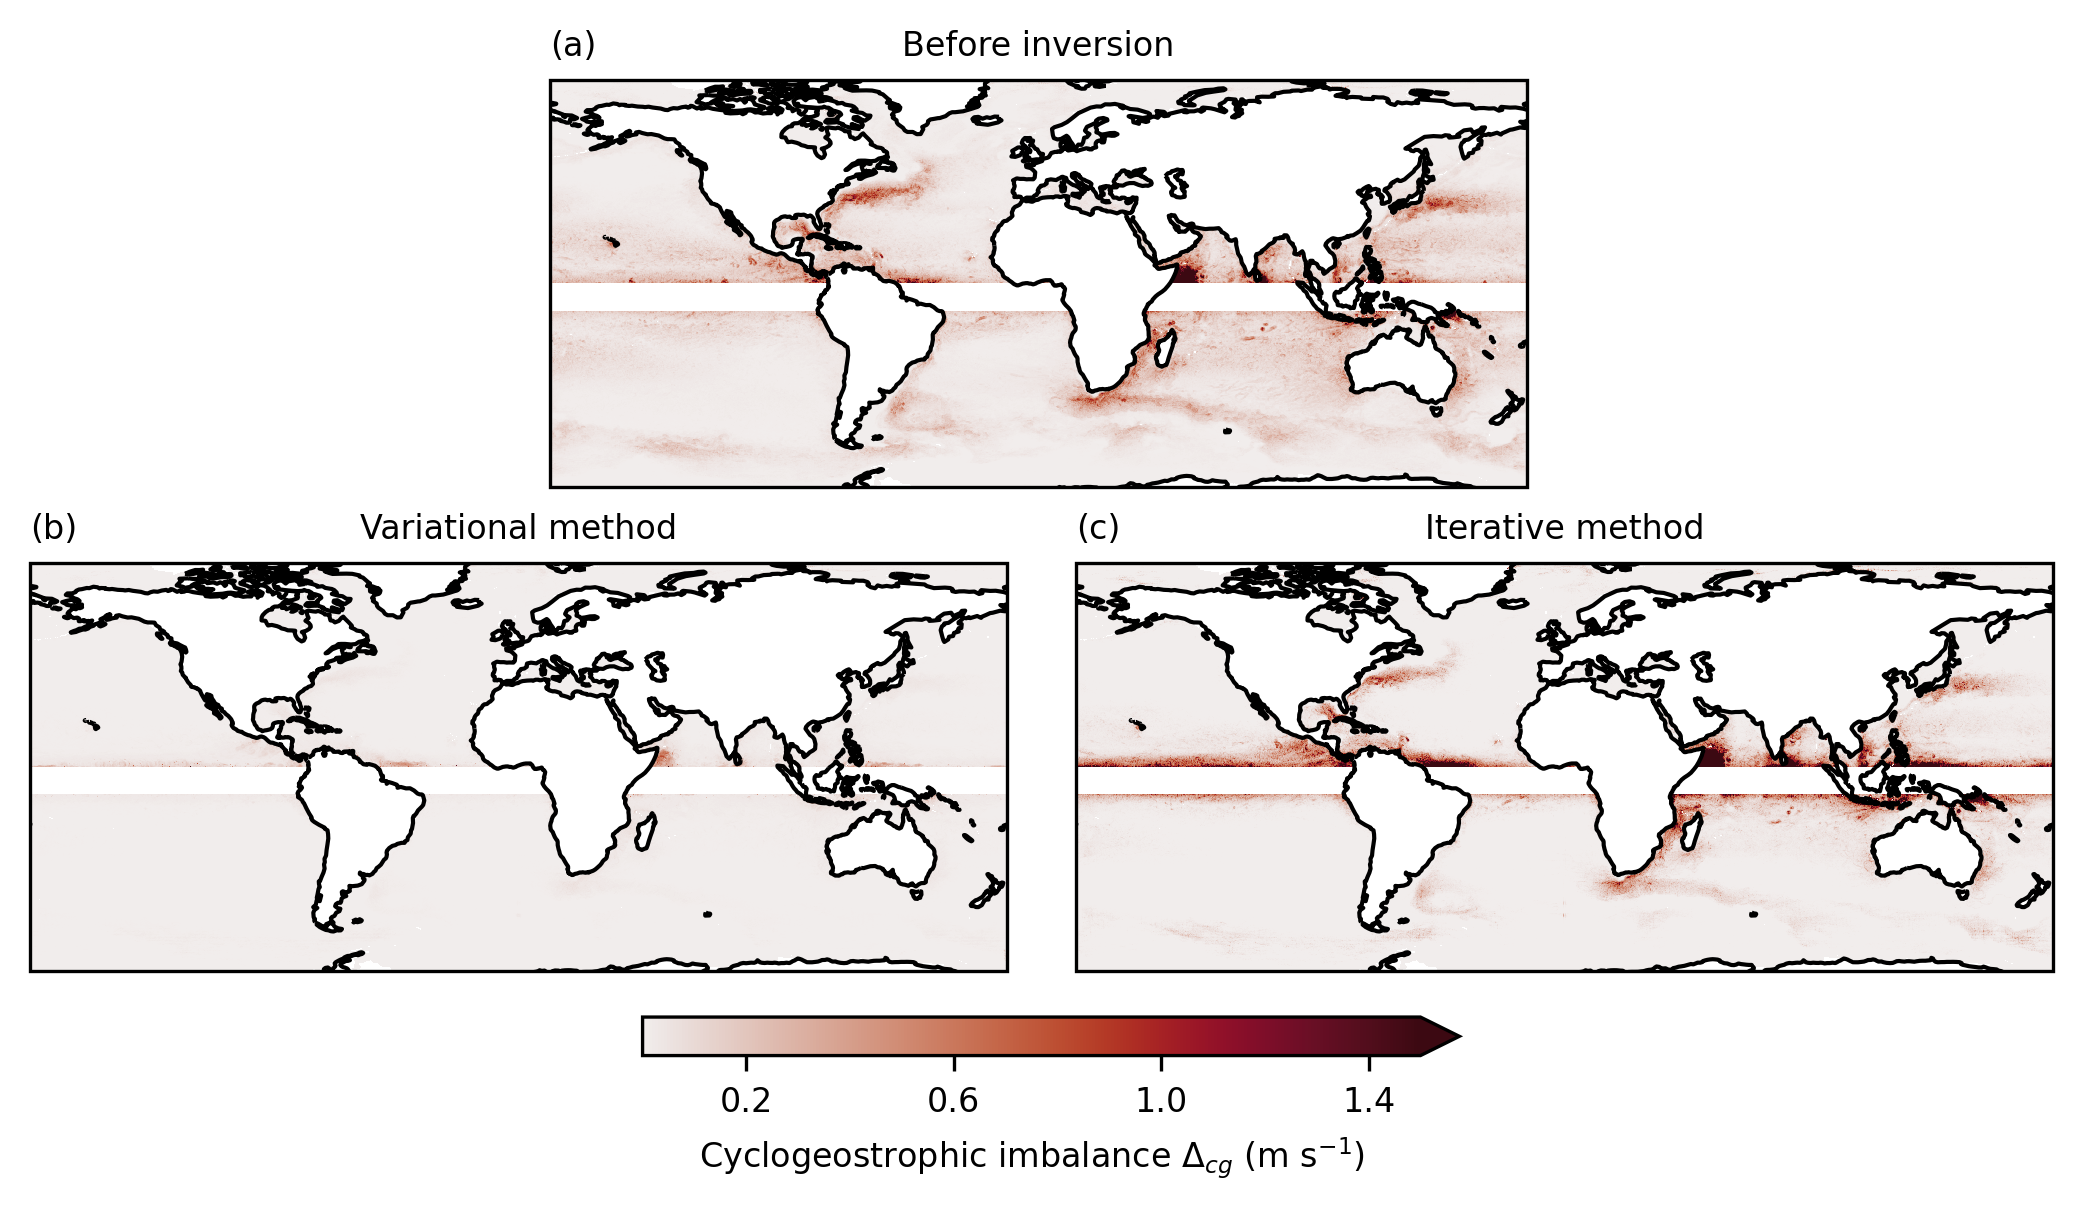

In [7]:
n_rows = 2
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - HW_SPACE * (n_cols - 1)) / n_cols * PLOT_NEUROST_GLOBAL_HW_RATIO + TITLE_H) * n_rows + 
        HW_SPACE * (n_rows - 1) + CLB_AXIS_HW + CLB_HW_SPACE * 5
    ),
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    ..AAAA..
    BBBBCCCC
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im = plot_uv_imbalance(
    neurost_imbalance_uv_Geostrophy.imbalance_uv_Geostrophy,
    neurost_imbalance_uv_Geostrophy.latitude, neurost_imbalance_uv_Geostrophy.longitude,
    "Before inversion", "(a)",
    axd["A"]
)

_ = plot_uv_imbalance(
    neurost_imbalance_uv_Cyclogeostrophy.imbalance_uv_Cyclogeostrophy,
    neurost_imbalance_uv_Cyclogeostrophy.latitude, neurost_imbalance_uv_Cyclogeostrophy.longitude,
    "Variational method", "(b)",
    axd["B"]
)

_ = plot_uv_imbalance( 
    neurost_it_imbalance_uv_Cyclogeostrophy.imbalance_uv_Cyclogeostrophy,
    neurost_it_imbalance_uv_Cyclogeostrophy.latitude, neurost_it_imbalance_uv_Cyclogeostrophy.longitude,
    "Iterative method", "(c)",
    axd["C"]
)

clb = fig.colorbar(
    im, ax=axd.values(), 
    **get_clb_kwargs(fig_width, fig_height, clb_location="bottom", clb_shrink=.4), 
    extend="max"
)
clb.set_label(label="Cyclogeostrophic imbalance $\Delta_{cg}$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0.2, 0.6 , 1.0, 1.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/f01.png", dpi=DPI, bbox_inches="tight")

plt.show()

# Snapshot - Figures 2

In [ ]:
neurost_snapshot = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_snapshot.nc")
neurost_snapshot_zoom = restrict_to_gulfstream(neurost_snapshot)
neurost_it_snapshot = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_it_snapshot.nc")
neurost_it_snapshot_zoom = restrict_to_gulfstream(neurost_it_snapshot)

In [ ]:
UV_MAX = 1.5
NRV_MAX = .5

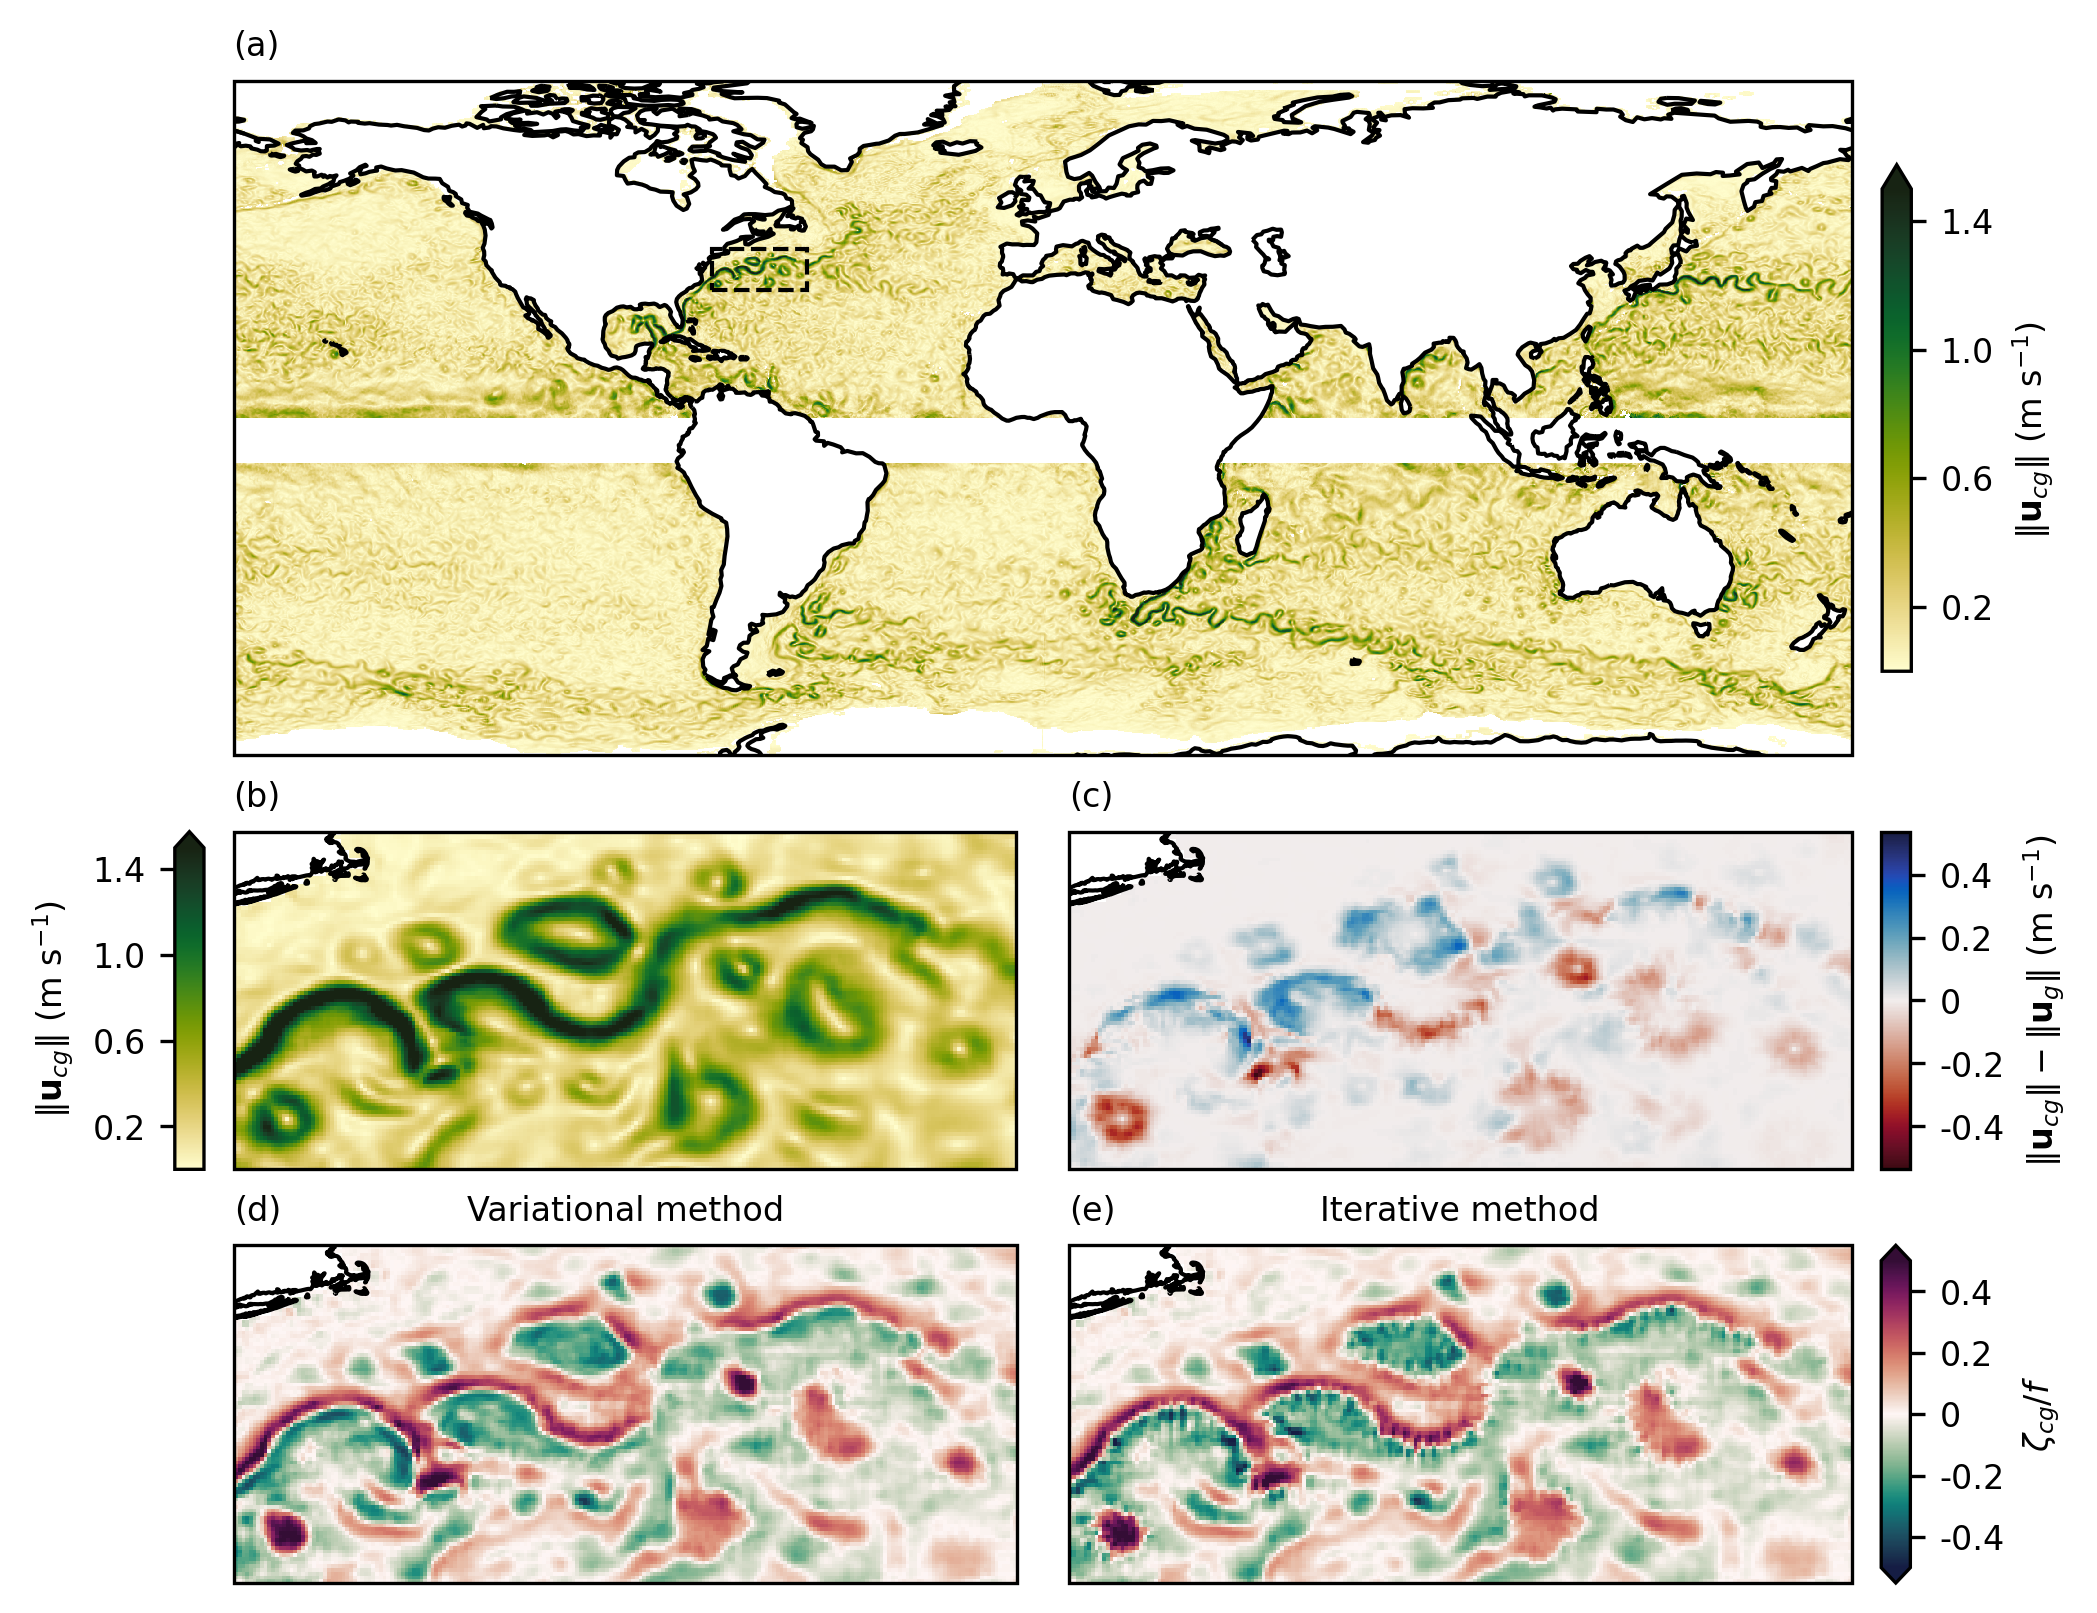

In [10]:
n_rows = 3
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - (CLB_AXIS_HW + CLB_HW_SPACE)) * PLOT_NEUROST_GLOBAL_HW_RATIO + TITLE_H) +
        (
            (
                fig_width - HW_SPACE * (n_cols - 1) - (CLB_AXIS_HW + CLB_HW_SPACE + TITLE_H)
            ) / n_cols * PLOT_GS_HW_RATIO + TITLE_H
        ) * (n_rows - 1) + 
        HW_SPACE * (n_rows - 1)
    ),
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    AA
    BC
    DE
    """,
    height_ratios=[2, 1, 1],
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im = axd["A"].pcolormesh(
    neurost_snapshot.longitude, neurost_snapshot.latitude, 
    neurost_snapshot.magn_Cyclogeostrophy,
    cmap=cmo.speed, vmin=0, vmax=UV_MAX,
    transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("(a)", loc="left", fontsize=FONT_SIZE)

axd["A"].add_patch(mpatches.Rectangle(
    xy=[neurost_snapshot_zoom.longitude.min(), neurost_snapshot_zoom.latitude.min()],
    width=neurost_snapshot_zoom.longitude.max() - neurost_snapshot_zoom.longitude.min(),
    height=neurost_snapshot_zoom.latitude.max() - neurost_snapshot_zoom.latitude.min(),
    linestyle="--", edgecolor="k", facecolor="none", linewidth=1
))

clb = fig.colorbar(
    im, ax=axd["A"],
    **get_clb_kwargs(fig_width, fig_height / 2, clb_location="right", clb_shrink=.75), 
    extend="max"
)
clb.set_label(label="$\| \mathbf{u}_{cg} \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0.2, 0.6 , 1.0, 1.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

im = axd["B"].pcolormesh(
    neurost_snapshot_zoom.longitude, neurost_snapshot_zoom.latitude, 
    neurost_snapshot_zoom.magn_Cyclogeostrophy,
    cmap=cmo.speed, vmin=0, vmax=UV_MAX,
    transform=ccrs.PlateCarree()
)
axd["B"].coastlines()
axd["B"].set_title("(b)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["B"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="left", clb_shrink=1), 
    extend="max"
)
clb.set_label(label="$\| \mathbf{u}_{cg} \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0.2, 0.6 , 1.0, 1.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

uv_diff = neurost_snapshot_zoom.magn_Cyclogeostrophy - neurost_snapshot_zoom.magn_Geostrophy
uv_diff_max = np.nanmax(np.abs(uv_diff))
im = axd["C"].pcolormesh(
    neurost_snapshot_zoom.longitude, neurost_snapshot_zoom.latitude, uv_diff,
    cmap=cmo.balance_r, vmin=-uv_diff_max, vmax=uv_diff_max,
    transform=ccrs.PlateCarree()
)
axd["C"].coastlines()
axd["C"].set_title("(c)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["C"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="right", clb_shrink=1)
)
clb.set_label(label="$\| \mathbf{u}_{cg} \| - \| \mathbf{u}_g \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [-0.4, -0.2 , 0, 0.2, 0.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

im = axd["D"].pcolormesh(
    neurost_snapshot_zoom.longitude, neurost_snapshot_zoom.latitude, 
    neurost_snapshot_zoom.nrv_Cyclogeostrophy,
    cmap=cmo.curl, vmin=-NRV_MAX, vmax=NRV_MAX,
    transform=ccrs.PlateCarree()
)
axd["D"].coastlines()
axd["D"].set_title("Variational method", fontsize=FONT_SIZE)
axd["D"].set_title("(d)", loc="left", fontsize=FONT_SIZE)

im = axd["E"].pcolormesh(
    neurost_it_snapshot_zoom.longitude, neurost_it_snapshot_zoom.latitude, 
    neurost_it_snapshot_zoom.nrv_Cyclogeostrophy,
    cmap=cmo.curl, vmin=-NRV_MAX, vmax=NRV_MAX,
    transform=ccrs.PlateCarree()
)
axd["E"].coastlines()
axd["E"].set_title("Iterative method", fontsize=FONT_SIZE)
axd["E"].set_title("(e)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=[axd["E"]],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="right", clb_shrink=1),
    extend="both"
)
clb.set_label(label="$\\zeta_{cg} / f$", size=FONT_SIZE)
tick_labels = [-0.4, -0.2 , 0, 0.2, 0.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/f02.png", dpi=DPI, bbox_inches="tight")

plt.show()

# EKE gain / loss - Figure 3

In [11]:
neurost_eke_diff_rel_Cyclogeostrophy_Geostrophy = xr.open_dataset(
    f"{DATA_FILES_PATH}/neurost_eke_diff_rel_Cyclogeostrophy_Geostrophy.nc"
)

In [12]:
EKE_DIFF_REL_MAX = 20

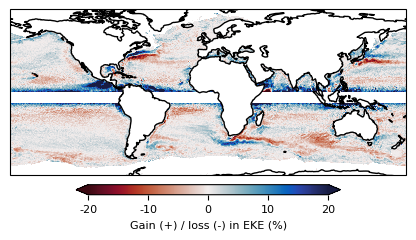

In [13]:
fig_width = MAX_WIDTH * .75
fig_height = min(fig_width * PLOT_NEUROST_GLOBAL_HW_RATIO + CLB_AXIS_HW + CLB_HW_SPACE, MAX_HEIGHT)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(fig_width, fig_height))

im = ax.pcolormesh(
    neurost_eke_diff_rel_Cyclogeostrophy_Geostrophy.longitude, neurost_eke_diff_rel_Cyclogeostrophy_Geostrophy.latitude, 
    neurost_eke_diff_rel_Cyclogeostrophy_Geostrophy.eke_diff_rel_Cyclogeostrophy_Geostrophy,
    cmap=cmo.balance_r, vmin=-EKE_DIFF_REL_MAX, vmax=EKE_DIFF_REL_MAX,
    transform=ccrs.PlateCarree()
)
ax.coastlines()

clb = fig.colorbar(
    im, ax=ax, 
    **get_clb_kwargs(fig_width, fig_height, clb_location="bottom", clb_shrink=.66), 
    extend="both"
)
clb.set_label(label="Gain (+) / loss (-) in EKE (%)", size=FONT_SIZE)
tick_labels = [-20, -10, 0, 10, 20]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/f03.png", dpi=DPI, bbox_inches="tight")

plt.show()

# RMS gain / loss - Figure 4

In [6]:
duacs_spatial_binned_errors_ds = xr.open_dataset(
    f"{DATA_FILES_PATH}/duacs_spatial_binned_errors_ds.nc"
)
neurost_spatial_binned_errors_ds = xr.open_dataset(
    f"{DATA_FILES_PATH}/neurost_spatial_binned_errors_ds.nc"
)

In [7]:
duacs_err_Geostrophy_rms = np.sqrt(
    duacs_spatial_binned_errors_ds.err_Geostrophy_mean ** 2 + duacs_spatial_binned_errors_ds.err_Geostrophy_sd ** 2
)
duacs_err_Cyclogeostrophy_rms = np.sqrt(
    duacs_spatial_binned_errors_ds.err_Cyclogeostrophy_mean ** 2 + 
    duacs_spatial_binned_errors_ds.err_Cyclogeostrophy_sd ** 2
)

neurost_err_Geostrophy_rms = np.sqrt(
    neurost_spatial_binned_errors_ds.err_Geostrophy_mean ** 2 + neurost_spatial_binned_errors_ds.err_Geostrophy_sd ** 2
)
neurost_err_Cyclogeostrophy_rms = np.sqrt(
    neurost_spatial_binned_errors_ds.err_Cyclogeostrophy_mean ** 2 + 
    neurost_spatial_binned_errors_ds.err_Cyclogeostrophy_sd ** 2
)

In [8]:
duacs_cg_rms_gain_loss = (duacs_err_Geostrophy_rms - duacs_err_Cyclogeostrophy_rms) / duacs_err_Geostrophy_rms * 100

neurost_cg_rms_gain_loss = (
    neurost_err_Geostrophy_rms - neurost_err_Cyclogeostrophy_rms
) / neurost_err_Geostrophy_rms * 100

duacs_neurost_rms_gain_loss = (
    duacs_err_Geostrophy_rms - neurost_err_Cyclogeostrophy_rms
) / duacs_err_Geostrophy_rms * 100

In [13]:
RMS_DIFF_REL_MAX = 20


def plot_sd_diff(
    rms_diff: xr.DataArray, latitude: xr.DataArray, longitude: xr.DataArray, title: str, label: str, ax: GeoAxes
):
    im = ax.pcolormesh(
        longitude, latitude, rms_diff,
        cmap=cmo.balance_r, vmin=-RMS_DIFF_REL_MAX, vmax=RMS_DIFF_REL_MAX,
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()

    ax.set_title(title, fontsize=FONT_SIZE)
    ax.set_title(label, loc="left", fontsize=FONT_SIZE)

    return im

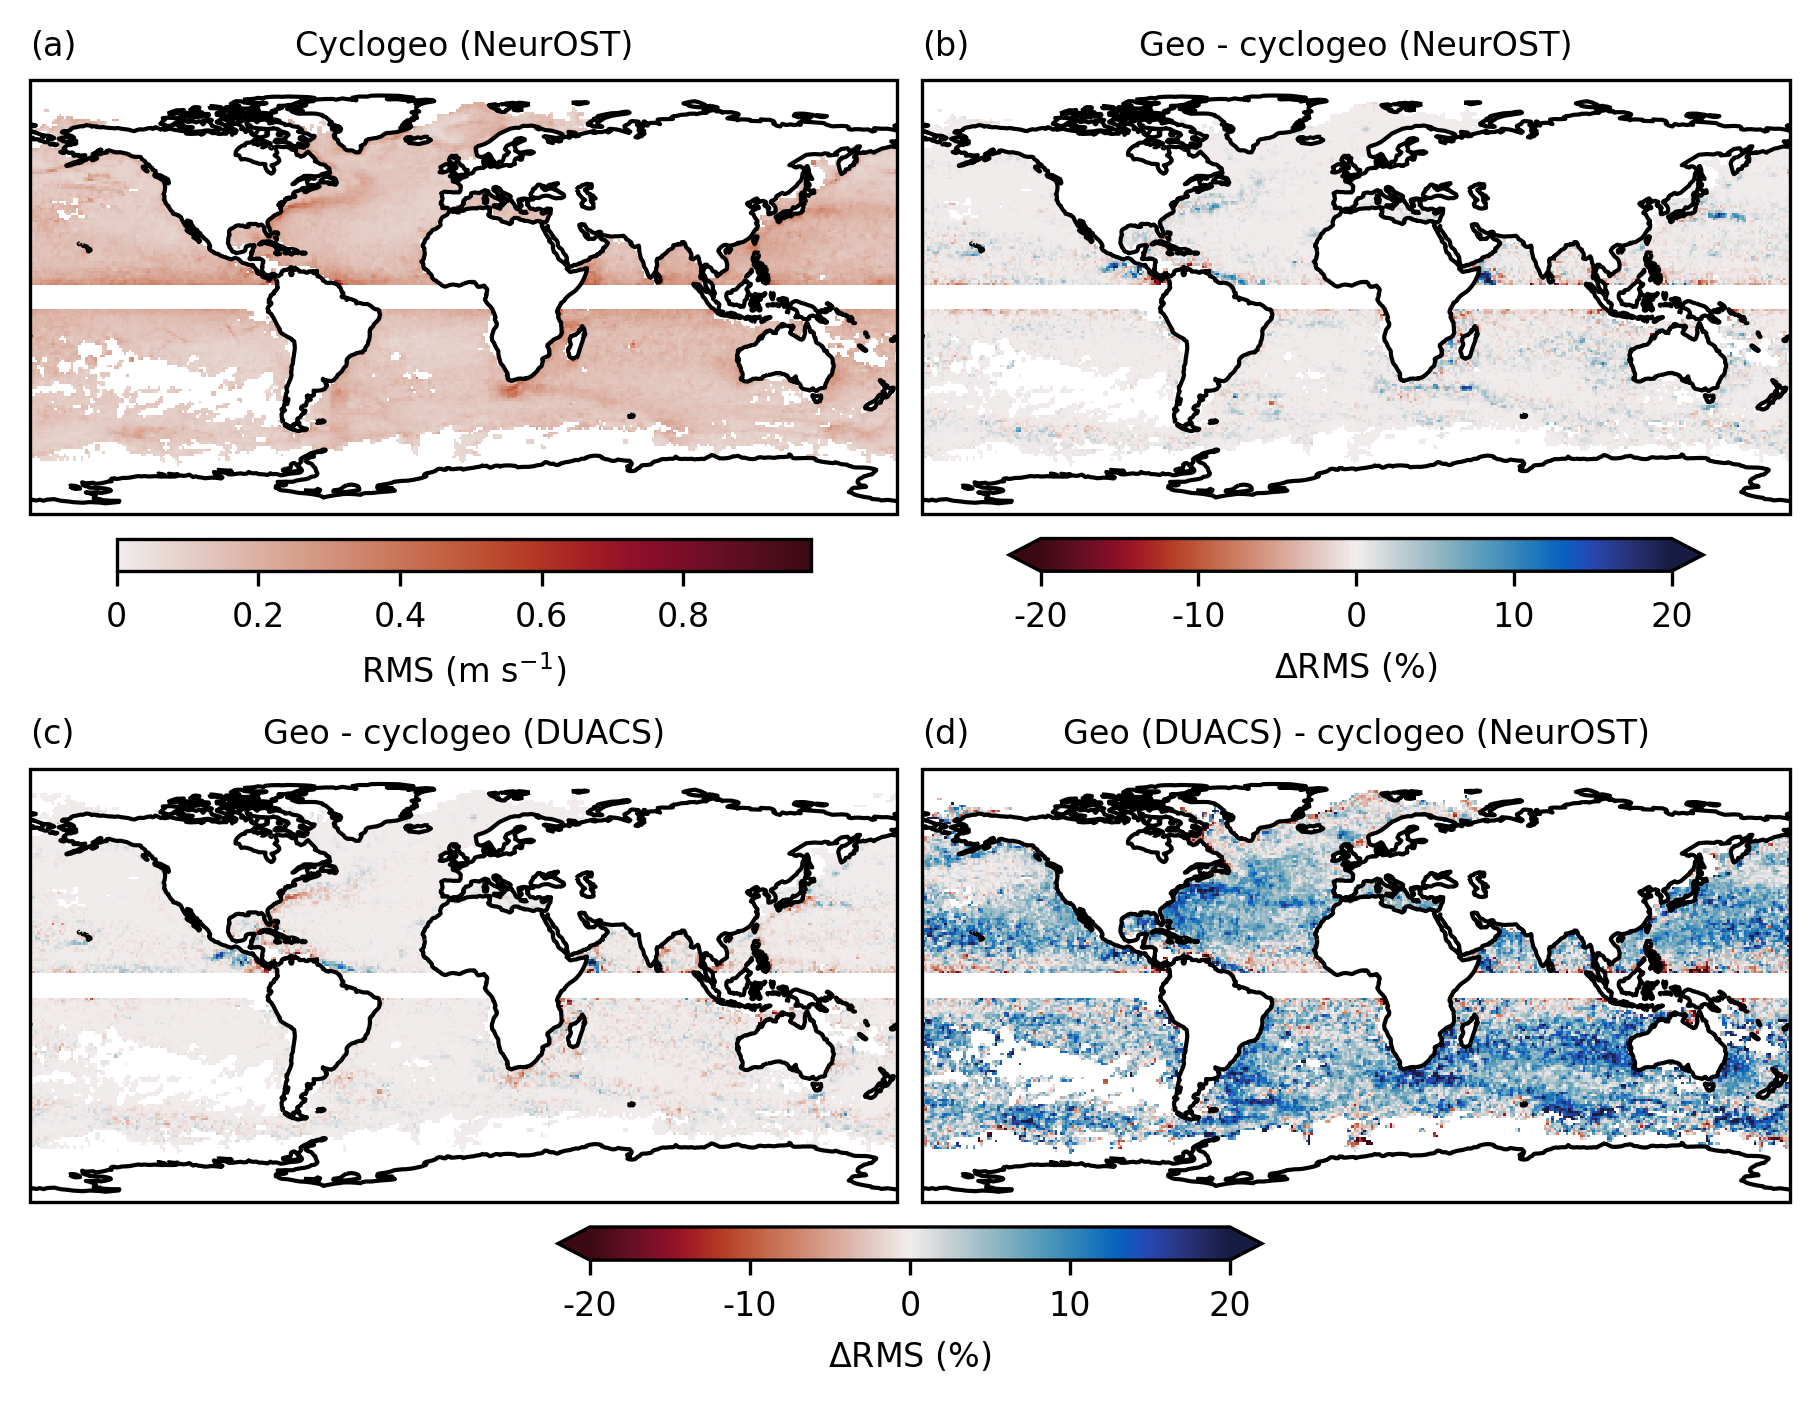

In [14]:
n_rows = 2
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - HW_SPACE * (n_cols - 1)) / n_cols * PLOT_NEUROST_GLOBAL_HW_RATIO + TITLE_H) * n_rows + 
        HW_SPACE * (n_rows - 1) + (CLB_AXIS_HW + CLB_HW_SPACE) * n_rows
    ),
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    AB
    CD
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im_sd = axd["A"].pcolormesh(
    neurost_spatial_binned_errors_ds.longitude, neurost_spatial_binned_errors_ds.latitude, 
    neurost_err_Cyclogeostrophy_rms,
    cmap=cmo.amp, vmin=0,
    transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("Cyclogeo (NeurOST)", fontsize=FONT_SIZE)
axd["A"].set_title("(a)", loc="left", fontsize=FONT_SIZE)

clb_sd = fig.colorbar(
    im_sd, ax=axd["A"], 
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="bottom", clb_shrink=.8)
)
clb_sd.set_label(label="$\\text{RMS}$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0, .2, .4, .6, .8]
clb_sd.set_ticks(tick_labels)
clb_sd.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

im_sd_diff = plot_sd_diff(
    neurost_cg_rms_gain_loss,
    neurost_spatial_binned_errors_ds.latitude, neurost_spatial_binned_errors_ds.longitude,
    "Geo - cyclogeo (NeurOST)",
    "(b)",
    axd["B"]
)

clb_sd_diff1 = fig.colorbar(
    im_sd_diff, ax=axd["B"],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="bottom", clb_shrink=.8), 
    extend="both"
)
clb_sd_diff1.set_label(label="$\Delta\\text{RMS}$ (%)", size=FONT_SIZE)
tick_labels = [-20, -10, 0, 10, 20]
clb_sd_diff1.set_ticks(tick_labels)
clb_sd_diff1.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

_ = plot_sd_diff(
    duacs_cg_rms_gain_loss,
    neurost_spatial_binned_errors_ds.latitude, neurost_spatial_binned_errors_ds.longitude,
    "Geo - cyclogeo (DUACS)",
    "(c)",
    axd["C"]
)

_ = plot_sd_diff(
    duacs_neurost_rms_gain_loss,
    neurost_spatial_binned_errors_ds.latitude, neurost_spatial_binned_errors_ds.longitude,
    "Geo (DUACS) - cyclogeo (NeurOST)",
    "(d)",
    axd["D"]
)

clb_sd_diff2 = fig.colorbar(
    im_sd_diff, ax=list(axd.values())[2:],
    **get_clb_kwargs(fig_width, fig_height / 2, clb_location="bottom", clb_shrink=.4), 
    extend="both"
)
clb_sd_diff2.set_label(label="$\Delta\\text{RMS}$ (%)", size=FONT_SIZE)
tick_labels = [-20, -10, 0, 10, 20]
clb_sd_diff2.set_ticks(tick_labels)
clb_sd_diff2.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.savefig(
    f"{FIGURES_PATH}/f04.png", dpi=DPI, bbox_inches="tight"
)

plt.show()

# Errors - Figure 5

In [ ]:
neurost_errors_to_drifters_df = pd.read_parquet(f"{DATA_FILES_PATH}/neurost_errors_to_drifters.parquet")
neurost_it_errors_to_drifters_df = pd.read_parquet(f"{DATA_FILES_PATH}/neurost_it_errors_to_drifters.parquet")
duacs_errors_to_drifters_df = pd.read_parquet(f"{DATA_FILES_PATH}/duacs_errors_to_drifters.parquet")
duacs_it_errors_to_drifters_df = pd.read_parquet(f"{DATA_FILES_PATH}/duacs_it_errors_to_drifters.parquet")

In [ ]:
def get_logit_fit(df):
    X = df["uv"].values
    Z = df["cyclogeostrophy_best_than_Geostrophy"].values

    bins = np.linspace(X.min(), X.max(), 200)
    bin_idx = np.digitize(X, bins)
    bin_mean_X = [X[bin_idx == i].mean() for i in range(1, len(bins))]
    bin_mean_Z = [Z[bin_idx == i].mean() for i in range(1, len(bins))]

    mask = ~np.isnan(bin_mean_X)
    bin_mean_X = np.array(bin_mean_X)[mask]
    bin_mean_Z = np.array(bin_mean_Z)[mask]

    X_pred = np.linspace(X.min(), X.max(), 200)

    bic_values = []
    degrees = range(2, 11)  # try between 2 and 10 degrees of freedom
    for deg in degrees:
        poly = PolynomialFeatures(degree=deg, include_bias=False)
        X_poly = poly.fit_transform(X.reshape(-1, 1))
        X_poly_const = sm.add_constant(X_poly)
        model = sm.Logit(Z, X_poly_const).fit(disp=False)
        bic_values.append(model.bic)
    poly_deg = degrees[np.argmin(bic_values)]

    poly = PolynomialFeatures(degree=poly_deg, include_bias=False)
    X_poly = poly.fit_transform(X.reshape(-1, 1))

    model = sm.Logit(Z, sm.add_constant(X_poly)).fit(disp=False)

    X_pred_poly = poly.transform(X_pred.reshape(-1, 1))
    poly_pred = model.get_prediction(sm.add_constant(X_pred_poly))
    poly_pred_summary = poly_pred.summary_frame(alpha=0.05)

    return bin_mean_X, bin_mean_Z, X_pred, poly_deg, poly_pred_summary

In [ ]:
neurost_logit_fit = get_logit_fit(neurost_errors_to_drifters_df)
neurost_it_logit_fit = get_logit_fit(neurost_it_errors_to_drifters_df)
duacs_logit_fit = get_logit_fit(duacs_errors_to_drifters_df)
duacs_it_logit_fit = get_logit_fit(duacs_it_errors_to_drifters_df)

In [ ]:
bin_mean_X, neurost_bin_mean_Z, X_pred, neurost_poly_deg, neurost_poly_pred_summary = neurost_logit_fit
_, neurost_it_bin_mean_Z, _, neurost_it_poly_deg, neurost_it_poly_pred_summary = neurost_it_logit_fit
_, duacs_bin_mean_Z, _, duacs_poly_deg, duacs_poly_pred_summary = duacs_logit_fit
_, duacs_it_bin_mean_Z, _, duacs_it_poly_deg, duacs_it_poly_pred_summary = duacs_it_logit_fit

In [ ]:
fig, ax = plt.subplots()

ax.plot(X_pred, duacs_it_poly_pred_summary["predicted"], color="tab:orange")
ax.fill_between(
    X_pred, duacs_it_poly_pred_summary["ci_lower"], duacs_it_poly_pred_summary["ci_upper"], 
    color="tab:orange", alpha=0.2
)
plt.plot(bin_mean_X, duacs_it_bin_mean_Z, ".", color="tab:orange", alpha=0.6)

ax.plot(X_pred, duacs_poly_pred_summary["predicted"], color="tab:blue")
ax.fill_between(
    X_pred, duacs_poly_pred_summary["ci_lower"], duacs_poly_pred_summary["ci_upper"], color="tab:blue", alpha=0.2
)
plt.plot(bin_mean_X, duacs_bin_mean_Z, ".", color="tab:blue", alpha=0.6)

ax.plot(X_pred, neurost_it_poly_pred_summary["predicted"], color="tab:red")
ax.fill_between(
    X_pred, neurost_it_poly_pred_summary["ci_lower"], neurost_it_poly_pred_summary["ci_upper"], color="tab:red", alpha=0.2
)
plt.plot(bin_mean_X, neurost_it_bin_mean_Z, ".", color="tab:red", alpha=0.6)

ax.plot(X_pred, neurost_poly_pred_summary["predicted"], color="tab:purple")
ax.fill_between(
    X_pred, neurost_poly_pred_summary["ci_lower"], neurost_poly_pred_summary["ci_upper"], color="tab:purple", alpha=0.2
)
plt.plot(bin_mean_X, neurost_bin_mean_Z, ".", color="tab:purple", alpha=0.6)

ax.hlines(
    0.5, xmin=neurost_errors_to_drifters_df["uv"].min(), xmax=neurost_errors_to_drifters_df["uv"].max(), 
    colors="grey", linestyles="--"
)

ax.set_xlabel("$\| \mathbf{u}_d \|$ (m s$^{-1}$)", size=FONT_SIZE)
ax.set_ylabel("P($\\varepsilon_{cg} < \\varepsilon_g$|$\| \mathbf{u}_d \|$)", size=FONT_SIZE)

ax.legend(fontsize=FONT_SIZE)

fig.tight_layout()

# plt.savefig(f"{FIGURES_PATH}/f05.png", dpi=DPI, bbox_inches="tight")

plt.show()

## Old version

In [120]:
neurost_eke_errors = pd.read_parquet(f"{DATA_FILES_PATH}/neurost_eke_errors.parquet")
duacs_eke_errors = pd.read_parquet(f"{DATA_FILES_PATH}/duacs_eke_errors.parquet")
neurost_it_eke_errors = pd.read_parquet(f"{DATA_FILES_PATH}/neurost_it_eke_errors.parquet")
duacs_it_eke_errors = pd.read_parquet(f"{DATA_FILES_PATH}/duacs_it_eke_errors.parquet")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/bertrava/projects/cyclogeostrophy_impact_experiment/paper-results-reproduction/data-files/duacs_eke_errors.parquet'

In [20]:
def get_errors(df, column, x_vals):
    errors = []
    for x_val in x_vals:
        error_values = df[df["eke"] == x_val][column].values
        errors.append(error_values[np.isfinite(error_values)])
    return errors

In [21]:
n_models = 6

x_labels = neurost_eke_errors["eke"].unique()
x_pos = np.arange(x_labels.size)
data = [
    get_errors(neurost_eke_errors, "err_Cyclogeostrophy", x_labels),
    get_errors(neurost_it_eke_errors, "err_Cyclogeostrophy", x_labels),
    get_errors(neurost_eke_errors, "err_Geostrophy", x_labels),
    get_errors(duacs_eke_errors, "err_Cyclogeostrophy", x_labels),
    get_errors(duacs_it_eke_errors, "err_Cyclogeostrophy", x_labels),
    get_errors(duacs_eke_errors, "err_Geostrophy", x_labels)
]
model_labels = [
    "NeurOST - cyclogeostrophy, variational",
    "NeurOST - cyclogeostrophy, iterative",
    "NeurOST - geostrophy",
    "DUACS - cyclogeostrophy, variational",
    "DUACS - cyclogeostrophy, iterative",
    "DUACS - geostrophy"
]
cmap = plt.get_cmap("Set2")
colors = [cmap(i) for i in range(n_models // 2)] + [cmap(i) for i in range(n_models // 2)]
linestyles = ["-", "-", "-", "--", "--", "--"]
width = .1
offset = np.linspace(-width * n_models / 2, width * n_models / 2, n_models)

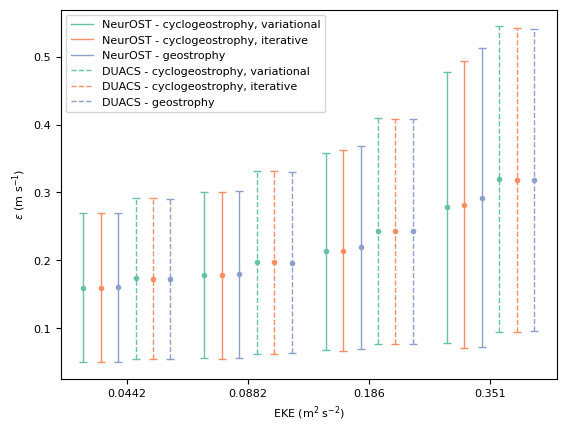

In [22]:
fig, ax = plt.subplots()

for i in range(n_models):
    positions = x_pos + offset[i] * 1.2
    mean = [np.mean(data[i][j]) for j in range(len(data[i]))]
    sd = [np.std(data[i][j]) for j in range(len(data[i]))]
    err_bar = ax.errorbar(
        positions, mean, yerr=sd, fmt="o", color=colors[i],
        label=model_labels[i], capsize=3, elinewidth=1, markersize=3
    )
    err_bar[-1][0].set_linestyle(linestyles[i])

ax.set_xticks(x_pos)
ax.set_xticklabels([f"{x:.3g}" for x in x_labels], fontsize=FONT_SIZE)
ax.legend([plt.Line2D([0], [0], color=colors[i], linestyle=linestyles[i], lw=1) for i in range(n_models)], model_labels)

ax.set_xlabel("EKE (m$^2$ s$^{-2}$)", size=FONT_SIZE)
ax.set_ylabel("$\\varepsilon$ (m s$^{-1}$)", size=FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/f05.png", dpi=DPI, bbox_inches="tight")

plt.show()